In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Outline

- linear model

- features / non-linear basis

linear / polynomial / Gaussian / sigmoid / Fourier

- maximum likelihood and least squares

- sequential learning <- start

- regularized least squares

- bias-variance decomposition

- Bayesian linear regression

- Baysesian model comparison

- the evidence approximation

#### RECALL 0

- model selection <- start

- the curse of dimensionality

- decision theory (or APPENDIX)

- information theory

#### RECALL 1

- polynomial curve fitting (linear)

- sum square error / MSE / RMSE

- coefficients $\textbf{w}$ / dataset size / model complexity $M$,$\lambda$

- regularization

- polynomial curve fitting (Bayesian)

- maximum a posterior (MAP)

#### RECALL 2

- Gaussian maximum likelihood <=> least squares

max (log) likelihood under Gaussian for linear model <=> min sum square error

- maximum likelihood underestimates the variance causing bias

#### RECALL 3

- probability theory

simple example / sum rule (marginalization) / product rule / Baye's theorem / independence

### Related Methods

- linear regression (with features)

- ridge regression (l2)

- lasso regression (l1)

- Bayesian linear regression

- Bayesian ridge regression 

...

# Linear Regression

- simplest forms: linear functions of the input variables

- more useful: linear combination of a fixed set of nonlinear functions of the input variables (**basis functions**)

such models are linear functions of the parameters, which gives them simple analytical properties, and yet can be nonlinear w.r.t the input variables

#### Setup

Given: $N$ observations $\{\textbf{x}_n\}$ with targets $\{t_n\}$

Goal: to predict $t$ for a new value $\textbf{x}$

a direct way: construct an approximation function $y(\textbf{x})$

from a probablistic view: model a predictive distribution $p(t|\textbf{x})$ by mminimizing the expected value of a loss function

the probablistic expression shows the uncertainty about the value of $t$ from each value of $\textbf{x}$

#### linear model pros and cons

(-) significant limitation in practice, particularly for high-dimensional state spaces

(+) nice analytical properties 

(+) form the foundation for more sophisticated models

#### linear combination of variables

$y(\textbf{x},\textbf{w})=w_0+w_1x_1+...+w_Dx_D$

where $\textbf{x}=(x_1,...,x_D)^T$

#### linear combinations of fixed nonlinear functions of variables

$y(\textbf{x},\textbf{w})=w_0+\sum_{j=1}^{M-1}w_j\phi_j(\textbf{x})$

$\phi_j(\textbf{x})$ - basis functions

$M$ - total number of parameters, including $w_0$

$w_0$ - bias parameter, allows for any fixed offset in the data 

for convenience, to define a dummy basis function $\phi_0(\textbf{x})=1$

$y(\textbf{x},\textbf{w})=\sum_{j=0}^{M-1}w_j\phi_j(\textbf{x})=\textbf{w}^T\boldsymbol{\phi}(\textbf{x})$

where $\textbf{w}=(w_0,...,w_{M-1})^T$, $\boldsymbol{\phi}=(\phi_0,...,\phi_{M-1})^T$

#### linear basis

a case of $\phi_j(x)=x$ of $y(\textbf{x},\textbf{w})=\sum_{j=0}^{M-1}w_j\phi_j(\textbf{x})=\textbf{w}^T\boldsymbol{\phi}(\textbf{x})$


#### polynomial basis (regression)

$\phi_j(x)=x^j$

limitation of polynomial basis function

(-) they are global functions of the input variable, so that changes in one region of input space affect all other regions

(solution) dividing the input space up into regions and fit a different polynomial in each region leading to **spline functions**

#### Gaussian basis

$\phi_j(x)=\exp \{- \frac{(x-\mu_j)^2}{2s^2}  \}$

$\mu_j$ - govern the locations of the basis function in input space

$s$ - govern their spatial scale

note: they are not required to have a probabilistic interpretation, the normalization coefficient is unimportant since $w_j$ is adaptive

#### sigmoid basis

$\phi_j(x)=\sigma \left( \frac{x-\mu_j}{s}  \right)$

where $\sigma(a)=\frac{1}{1+\exp(-a)}$ is logistic sigmoid function

note: $\tanh(a)=2\sigma(a)-1$ 

#### Fourier basis

an expansion in sinusoidal functions

each basis represents a specific frequency and has infinite spatial extent

**wavelets** functions

applicable when input:

- live on a regular lattice, such as successive time points in a temporal sequence

- pixels in an image



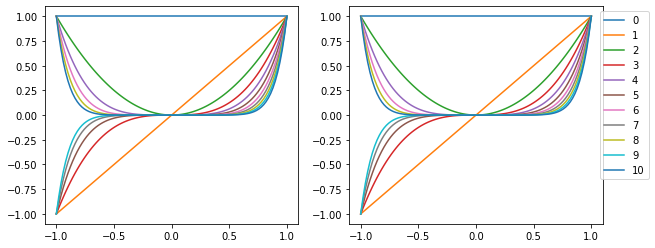

In [2]:
from sklearn.preprocessing import PolynomialFeatures

x=np.linspace(-1,1,100)
#x.shape (100,1), x[:,None].shape (100,1), or x.reshape(-1,1) (100,1)
x_poly=PolynomialFeatures(degree=11).fit_transform(x[:,None])
#x_poly=PolynomialFeatures(degree=11).fit(x.reshape(-1, 1))

#x_poly.shape (100,12)
plt.figure(figsize=(10,4))
degree=11
plt.subplot(121)
for i in range(degree):
    sns.lineplot(x=x,y=x**i)

#plt.legend(bbox_to_anchor=(1.2, 1))

plt.subplot(122)
for i in range(degree):
    sns.lineplot(x=x,y=x_poly[:,i],label=str(i))

plt.legend(bbox_to_anchor=(1.2, 1))

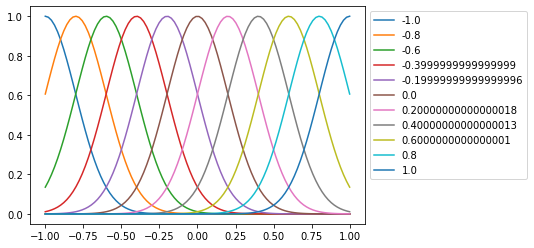

In [3]:
x=np.linspace(-1,1,100)
mu=np.linspace(-1,1,11)
s=0.2

for i in range(len(mu)):
    sns.lineplot(x=x,y=np.exp(-((x-mu[i])**2)/(2*s**2)),label=str(mu[i]))

plt.legend(bbox_to_anchor=(1.5, 1))

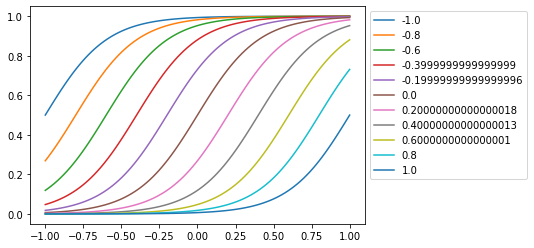

In [4]:
x=np.linspace(-1,1,100)
mu=np.linspace(-1,1,11)
s=0.2

for i in range(len(mu)):
    sns.lineplot(x=x,y=1/(1+np.exp(-(x-mu[i])/s)),label=str(mu[i]))

plt.legend(bbox_to_anchor=(1.5, 1))

# Maximum likelihood and least squares

assume target: 

$t=y(\textbf{x},\textbf{w})+\epsilon$

$\epsilon$ - zero mean Gaussian with precision (inverse variance) $\beta$

then 

$p(t|\textbf{x},\textbf{w},\beta)=\mathcal{N} (t|y(\textbf{x},\textbf{w}),\beta^{-1})$, (eq1)

the conditional mean

$\mathbb{E} [t|\textbf{x}]=\int tp(t|\textbf{x})dt=y(\textbf{x},\textbf{w})$

consider a date set and a target vector

$\textbf{X}=\{\textbf{x}_1,...,\textbf{x}_N\}$

$\textbf{t}=\{t_1,...,t_N\}$

assume these data points are drawn independently from the distribution of (eq1)

we obtain the **likelihood** function as 

$p(\textbf{t}|\textbf{X},\textbf{w},\beta)=\prod_{n=1}^N \mathcal{N}(t_n|\textbf{w}^T\boldsymbol{\phi}(\textbf{x}_n),\beta^{-1})$

where $y(\textbf{x},\textbf{w})=\textbf{w}^T\boldsymbol{\phi}(\textbf{x})$

take the **log of likelihood**

$\ln p(\textbf{t}|\textbf{w},\beta)=\sum_{n=1}^N \ln \mathcal{N}(t_n|\textbf{w}^T\boldsymbol{\phi}(\textbf{x}_n),\beta^{-1})$

$=N/2 \ln \beta - N/2 \ln (2\pi)-\beta/2 \sum_{n=1}^N \{t_n- \textbf{w}^T\boldsymbol{\phi}(\textbf{x}_n)\}^2 $

$E_D(\textbf{w})=1/2 \sum_{n=1}^N \{t_n- \textbf{w}^T\boldsymbol{\phi}(\textbf{x}_n)\}^2$ - sum-of-squares error

we can use **maximum likelihood** to determine $\textbf{w}$ and $\beta$

**maximization of the likelihood function under a conditional Gaussian noise distribution for a linear model is equivalent to minimizing a sum-of-squares error function (as above)**

the gradient of **log likelihood** w.r.t $\textbf{w}$ is

$\nabla \ln p(\textbf{t}|\textbf{w},\beta)=\sum_{n=1}^N \{ t_n - \textbf{w}^T\boldsymbol{\phi}(\textbf{x}_n)\}\boldsymbol{\phi}(\textbf{x}_n)^T$

set this gradient to 0, we have

$\textbf{w}_{ML}=(\Phi^T\Phi)^{-1}\Phi^T\textbf{t}$

$\Phi=$ 

$\begin{pmatrix}
\phi_0(x_1) & \phi_1(x_1) & ... & \phi_{M-1}(x_1)\\
\phi_0(x_2) & \phi_1(x_2) & ... & \phi_{M-1}(x_2)\\
... & ... & ... & ...\\
\phi_0(x_N) & \phi_1(x_N) & ... & \phi_{M-1}(x_N)\\
\end{pmatrix}$

$\Phi$ <- design matrix, NxM, $\Phi_{nj}=\phi_j(x_n)$

take the gradient of **log likelihood** w.r.t $\beta$

$1/\beta_{ML}=1/N \sum_{n=1}^N \{t_n-\textbf{w}_{ML}^T \phi(\textbf{x}_n) \}$

# RECALL 1 - polynomial curve fitting

- generalization (from training points to test points)

- pre-processing for fast computing 

featrue extraction/dimension reduction

- density estimation

to determine the distribution of data within the input space

- credit assignment (in RL)

the reward must be attributed appropriately to all of the moves that led to it

- trade-off between exploration and exploitation (key performance of RL)

# linear regression for poly

#### polynomial curve fitting from linear regression

data ~ $\sin(2\pi x)$ + random noise

Given $N$ observation $\textbf{x} \equiv (x_1,...,x_N)^T$, $\textbf{t} \equiv (t_1,...,t_N)^T$

Goal: exploit the training set to make predictions of $\hat{t}$ for some new $\hat{x}$

3 ways to approach:

1. linear regression, minimizing the error function (least square)

2. probability theory, provides a framework for expressing such uncertainty in a precise and quantitative manner

3. decision theory, exploits this probabilistic representation in order to make predictions that are optimal according to appropriate criteria

**polynomial function**

we use a polynomial function

$y(x,\textbf{w})=w_0+w_1x+x_2x^2+...+w_Mx^M=\sum_{j=0}^M w_j x^j$

to fit the data

$M$ - order of the polynomial

**linear model** - functions are linear in the unknown parameters 

**minimizing the sum of the squares of the errors**

$E(\textbf{w})=1/2 \sum_{n=1}^N \{y(x_n,\textbf{w}) -t_n \}^2$

by minimizing $E(\textbf{w})$, we can find $\textbf{w}^*$ in closed form

**model selection** - choose the order $M$ of the polynomial

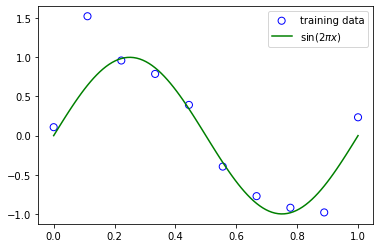

In [5]:
x=np.linspace(0,1,10) #sample size=10

#std 0.25
t=np.sin(2*np.pi*x)+np.random.normal(scale=0.25,size=x.shape)

x_train,y_train=x,t

x_test=np.linspace(0,1,100)
y_test=np.sin(2*np.pi*x_test)

plt.scatter(x_train,y_train,facecolor='none',edgecolor='b',s=50,label='training data')
plt.plot(x_test,y_test,c='g',label='$\sin(2\pi x)$')
plt.legend()

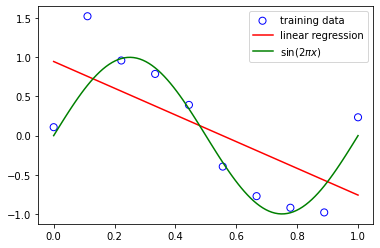

In [6]:
from sklearn.linear_model import LinearRegression

#x_train shape (n,1), y_train shape (n,)
#x_test shape (n,1)

lr=LinearRegression()
lr.fit(x_train.reshape(-1,1),y_train)
y_pred=lr.predict(x_test.reshape(-1,1))

plt.scatter(x_train,y_train,facecolor='none',edgecolor='b',s=50,label='training data')
plt.plot(x_test,y_pred,c='r',label='linear regression')
plt.plot(x_test,y_test,c='g',label='$\sin(2\pi x)$')
plt.legend()

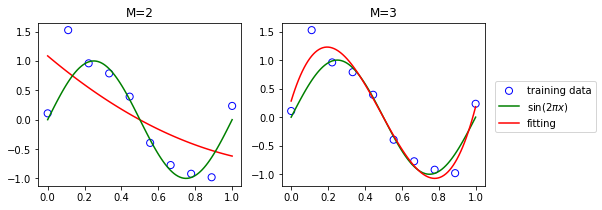

In [7]:
from sklearn.preprocessing import PolynomialFeatures

#feature with M degree 3
#feature_train shape (10,3), y_train (10,1)
#feature_test shape (10,3)
f2_train=np.array([x_train,x_train**2]).T
f2_test=np.array([x_test,x_test**2]).T

lr.fit(f2_train,y_train)
f2_pred=lr.predict(f2_test)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.scatter(x_train,y_train,facecolor='none',edgecolor='b',s=50,label='training data')
plt.plot(x_test,f2_pred,c='r',label='linear regression M=2')
plt.plot(x_test,y_test,c='g',label='$\sin(2\pi x)$')
plt.title('M=2')
#plt.legend()

f3_train=PolynomialFeatures(degree=3).fit_transform(x_train.reshape(-1,1))
f3_test=PolynomialFeatures(degree=3).fit_transform(x_test.reshape(-1,1))

lr.fit(f3_train,y_train)
f3_pred=lr.predict(f3_test)
plt.subplot(122)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, f3_pred, c="r", label="fitting")
plt.title('M=3')
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)

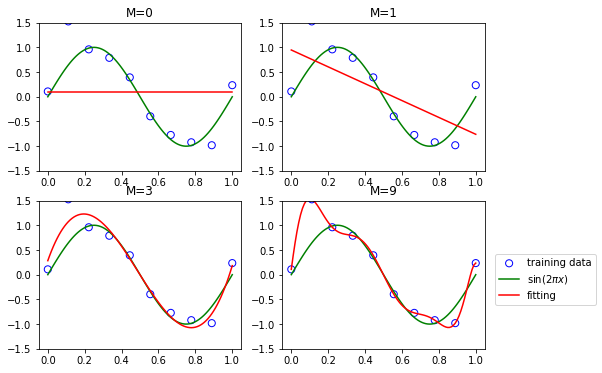

In [8]:
from sklearn.preprocessing import PolynomialFeatures

plt.figure(figsize=(8,6))
for i,d in enumerate([0,1,3,9]):
    plt.subplot(2,2,i+1)
    f_train=PolynomialFeatures(degree=d).fit_transform(x_train.reshape(-1,1))
    f_test=PolynomialFeatures(degree=d).fit_transform(x_test.reshape(-1,1))
    
    lr.fit(f_train,y_train)
    f_pred=lr.predict(f_test)
    
    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test,f_pred, c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.title('M='+str(d))

plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)



M=9 has no error between data point and fitted curve , however, it's overfitted to the pattern

recall: training set (10,1) points, test set (100,1) points

**sum square error**

$E(\textbf{w})=1/2 \sum_{n=1}^N \{y(x_n,\textbf{w}) -t_n \}^2$

**mean square error (MSE)**

$E_{MSE} = 1/N \sum_{n=1}^N \{y(x_n,\textbf{w}) -t_n \}^2=2E(\textbf{w})/N$

**root mean square error (RMSE)**

$E_{RMSE} = \sqrt{2E(\textbf{w})/N}$

division by N allows us to compare different sizes of data sets on equal footing

Text(0, 0.5, 'RMSE')

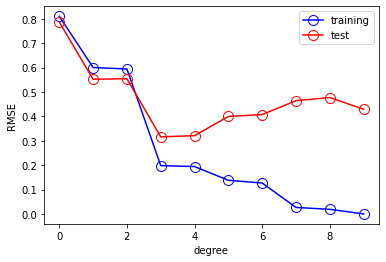

In [9]:
def rmse(y,y_hat):
    return np.sqrt(np.mean(np.square(y-y_hat)))

training_err=[]
test_err=[]
param=[]
noise=np.random.normal(scale=0.25,size=len(y_test))

for i in range(10):
    f_train=PolynomialFeatures(degree=i).fit_transform(x_train.reshape(-1,1))
    f_test=PolynomialFeatures(degree=i).fit_transform(x_test.reshape(-1,1))
    lr.fit(f_train,y_train)
    param.append(lr.coef_)
    training_err.append(rmse(lr.predict(f_train),y_train))
    test_err.append(rmse(lr.predict(f_test),y_test+noise))
    
plt.plot(training_err,'o-',mfc='none',mec='b',ms=10,c='b',label='training')
plt.plot(test_err,'o-',mfc='none',mec='r',ms=10,c='r',label='test')
plt.legend()
plt.xlabel('degree')
plt.ylabel('RMSE')

**examine the coefficients**

with the degree increasing, the coefficients have become finely tuned to the data by **developing large positive and negative values**

so that the corresponding polynomial function matches each of the data points exactly

**but**, between data points the function exhibits the large oscillations 

this means, **the coefficnets are well tuned to the noise inside the data**

In [10]:
np.set_printoptions(suppress=True)
for i in range(10):
    print('degree='+str(i)+', w='+str(np.round(param[i],decimals=0)))

degree=0, w=[0.]
degree=1, w=[ 0. -2.]
degree=2, w=[ 0. -3.  1.]
degree=3, w=[  0.  11. -34.  23.]
degree=4, w=[  0.  12. -42.  36.  -6.]
degree=5, w=[   0.   21. -112.  235. -234.   91.]
degree=6, w=[   0.   26. -179.  522. -789.  585. -164.]
degree=7, w=[    0.    48.  -547.  2705. -6961.  9586. -6697.  1866.]
degree=8, w=[     0.     56.   -707.   3909. -11505.  19046. -17733.   8623.  -1689.]
degree=9, w=[      0.      28.     -54.   -1965.   16090.  -56135.  105370. -110779.
   61483.  -14038.]


**examine the size of dataset**

the over-fitting problem become less severe as the size of the data set increases

- **the larger the data set, the more complex/flexible the model that we can afford to fit to the data**

- one rough heuristic: \# data points should be no less than some multiple (5 or 10) of \# adaptive parameters in the model

- however, \# parameters is not necessarily the most appropriate measure of model complexity

try to choose the complexity of the model according to the compelxity of the problem being solved

- least square is a special case of maximum likelihood

the over-fitting problem can be understood as a general property of maximum likelihood

- baysian approach can handle models for which \# parameters greatly exceeds \# data points

in Bayesian, the effective \# parameters adapts automatically to \# data points

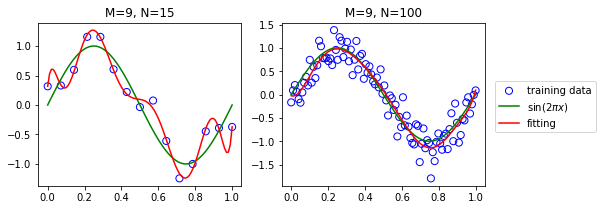

In [11]:
x_15=np.linspace(0,1,15) #sample size=15
x_100=np.linspace(0,1,100) #sample size=15

#std 0.25
t_15=np.sin(2*np.pi*x_15)+np.random.normal(scale=0.25,size=x_15.shape)
t_100=np.sin(2*np.pi*x_100)+np.random.normal(scale=0.25,size=x_100.shape)

x_train_15,y_train_15=x_15,t_15
x_train_100,y_train_100=x_100,t_100

x_test=np.linspace(0,1,100)
y_test=np.sin(2*np.pi*x_test)

f9_train_15=PolynomialFeatures(degree=9).fit_transform(x_train_15.reshape(-1,1))
f9_test_15=PolynomialFeatures(degree=9).fit_transform(x_test.reshape(-1,1))

f9_train_100=PolynomialFeatures(degree=9).fit_transform(x_train_100.reshape(-1,1))
f9_test_100=PolynomialFeatures(degree=9).fit_transform(x_test.reshape(-1,1))

lr.fit(f9_train_15,y_train_15)
f9_pred_15=lr.predict(f9_test_15)
param_15=lr.coef_

lr.fit(f9_train_100,y_train_100)
f9_pred_100=lr.predict(f9_test_100)
param_100=lr.coef_

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.scatter(x_train_15,y_train_15,facecolor='none',edgecolor='b',s=50,label='training data')
plt.plot(x_test,y_test,c='g',label='$\sin(2\pi x)$')
plt.plot(x_test,f9_pred_15, c="r", label="fitting")
plt.title('M=9, N=15')
#plt.legend()

plt.subplot(122)
plt.scatter(x_train_100,y_train_100,facecolor='none',edgecolor='b',s=50,label='training data')
plt.plot(x_test,y_test,c='g',label='$\sin(2\pi x)$')
plt.plot(x_test,f9_pred_100, c="r", label="fitting")
plt.title('M=9, N=100')
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)

In [12]:
np.set_printoptions(suppress=True)
print('degree=9, N=15, w='+str(np.round(param_15,decimals=0)))
print('degree=9, N=100, w='+str(np.round(param_100,decimals=0)))

degree=9, N=15, w=[      0.      29.    -924.   10697.  -58729.  176305. -306958.  309339.
 -167372.   37613.]
degree=9, N=100, w=[     0.     -2.     90.   -293.   -760.   6314. -15599.  19138. -11803.
   2915.]


**limited size dataset for relatively complex/flexible models**

**regularization** - one tech to control over-fitting, by adding penalty term to the error funciton to discourage the coefficients from reaching large values

$\tilde{E}(\textbf{w})=1/2 \sum_{n=1}^N \{y(x_n,\textbf{w})-t_n\}^2 + \lambda/2 ||\textbf{w}||^2$

$||\textbf{w}||^2=\textbf{w}^T\textbf{w}=w_0^2+w_1^2+...+w_M^2$

$\lambda$ - governs the relative importance of the regularization term compared with the sum-of-square error

$w_0$ is often omitted, because its inclusion causes the results to depend on the choice of origin for the target variable

regularization also called **shrinkage method**, because they reduce the value of the coefficients

**ridge regression** - linear least squares with a quadratic/l2 norm regularizer (or weight decay in nn)

**lasso regression** - a l1 norm

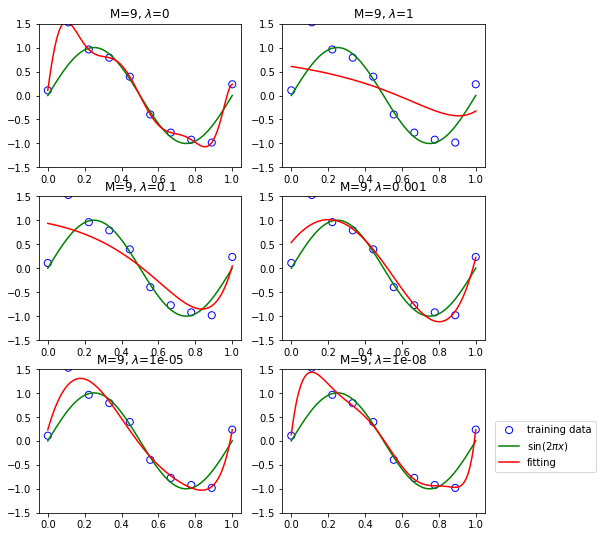

In [13]:
from sklearn.linear_model import Ridge

f9_train=PolynomialFeatures(degree=9).fit_transform(x_train.reshape(-1,1))
f9_test=PolynomialFeatures(degree=9).fit_transform(x_test.reshape(-1,1))

lamb=[0,1,0.1,0.001,1e-5,1e-8]
param=[]

plt.figure(figsize=(8,9))
for i,l in enumerate(lamb):
    rr=Ridge(alpha=l) #alpha is lambda
    rr.fit(f9_train,y_train)
    param.append(rr.coef_)
    f9_pred=rr.predict(f9_test)

    plt.subplot(3,2,i+1)
    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, f9_pred, c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.title('M=9, $\lambda$='+str(l))

    
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)

In [14]:
np.set_printoptions(suppress=True)
for l,p in zip(lamb,param):
    print('degree=9, lambda='+str(l)+', w='+str(np.round(p,decimals=2)))

degree=9, lambda=0, w=[      0.        27.95     -54.4    -1964.93   16090.23  -56134.71
  105370.07 -110779.03   61483.28  -14038.33]
degree=9, lambda=1, w=[ 0.   -0.61 -0.54 -0.34 -0.17 -0.03  0.08  0.16  0.23  0.28]
degree=9, lambda=0.1, w=[ 0.   -0.77 -1.47 -1.   -0.45  0.    0.35  0.62  0.84  1.  ]
degree=9, lambda=0.001, w=[  0.     4.73 -11.48  -1.83   2.66   3.29   2.34   1.02  -0.12  -0.92]
degree=9, lambda=1e-05, w=[  0.    13.44 -49.08  39.27  13.49  -8.42 -13.02  -8.43   0.44  12.3 ]
degree=9, lambda=1e-08, w=[    0.      30.78  -250.82   852.16 -1279.25   345.89   886.37  -187.44
  -909.62   512.02]


$\lambda=0$, no regularization

$\lambda=1,0.1$, large $\lambda$, poor performance

$\lambda$ now controls the effective complexity of the model and hence determines the degress of over-fitting (figure below)


Text(0, 0.5, 'RMSE')

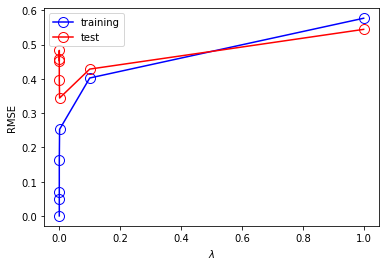

In [15]:
training_err=[]
test_err=[]
param=[]
#lambs=np.linspace(np.exp(-40),np.exp(-20),10)
#lambs=np.linspace(0.1,np.exp(-40),10)
lambs=[1,0.1,0.001,1e-5,1e-8,np.exp(-20),0]
noise=np.random.normal(scale=0.25,size=len(y_test))

for l in lambs:
    rr=Ridge(alpha=l) #alpha is lambda
    rr.fit(f9_train,y_train)
    param.append(rr.coef_)
    training_err.append(rmse(rr.predict(f9_train),y_train))
    test_err.append(rmse(rr.predict(f9_test),y_test+noise))
    
plt.plot(lambs,training_err,'o-',mfc='none',mec='b',ms=10,c='b',label='training')
plt.plot(lambs,test_err,'o-',mfc='none',mec='r',ms=10,c='r',label='test')
plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

**so far**

data -> training set + test set(hold-out set)

use training set to determine the coefficients $\textbf{w}$

use test set to optimize the model complexity $M$ or $\lambda$

# Bayesian regression for poly

#### polynomial curve fitting from probabilistic perspective

data ~ $\sin(2\pi x)$ + random noise

Given $N$ observation $\textbf{x} \equiv (x_1,...,x_N)^T$, $\textbf{t} \equiv (t_1,...,t_N)^T$

Goal: exploit the training set to make predictions of $\hat{t}$ for some new $\hat{x}$

recall: $y(x,\textbf{w})=w_0+w_1x+x_2x^2+...+w_Mx^M=\sum_{j=0}^M w_j x^j$

assume: given $x$, the corresponding $t$ has a Gaussian distribution with a mean $=y(x,\textbf{w})$, and a precision $\beta$

$p(t|x,\textbf{w},\beta)=\mathcal{N}(t|y(x,\textbf{w}),\beta^{-1})$

$\beta^{-1}=\sigma^2$

now, we use the training data $\{\textbf{x},\textbf{t}\}$ to determine $\textbf{w}$ and $\beta$ by maximum likelihood

assume data is drawn i.i.d from $p(t|x,\textbf{w},\beta)$

the **likelihood**:

$p(\textbf{t}|\textbf{x},\textbf{w},\beta)=\prod_{n=1}^N \mathcal{N}(t_n|y(x_n,\textbf{w}),\beta^{-1})$

the **log likelihood**:

$\ln p(\textbf{t}|\textbf{x},\textbf{w},\beta) = -\beta/2 \sum_{n=1}^N \{y(x_n,\textbf{w})-t_n\}^2+N/2 \ln \beta - N/2 \ln(2\pi)$

**max log likelihood <=> min negative log likelihood**

**max log likelihood <=> min sum-of-squares error under the Gaussian noise assumption**

let $\textbf{w}_{ML}$ be the max-log-likelihood solution for the polynomial coefficients 

$1/\beta_{ML}=1/N \sum_{n=1}^N \{y(x_n,\textbf{w}_{ML})-t_n\}^2$

now we have

$p(t|x,\textbf{w}_{ML},\beta_{ML})=\mathcal{N}(t|y(x,\textbf{w}_{ML}),\beta_{ML}^{-1})$

**instead of an estimated point of t, now we have a distribution over t**

we can start **Bayesian** approach by introducint a prior over the polynomial coefficients $\textbf{w}$ and it's Gaussian

**prior**:

$p(\textbf{w}|\alpha)=\mathcal{N} (\textbf{w}|\textbf{0},\alpha^{-1}\textbf{I})$

$\alpha$ - precision

$M+1$ - total \# elements in the vector $\textbf{w}$ for an Mth order polynomial

recall **Multivariate Gaussian**

$\mathcal{N}(\textbf{x}|\boldsymbol{\mu},\boldsymbol{\Sigma})=\frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \{-1/2 (\textbf{x}-\boldsymbol{\mu})^T \Sigma^{-1}(\textbf{x}-\boldsymbol{\mu}) \}$

$\boldsymbol{\mu}$ - D-dimensional mean vector

$\boldsymbol{\Sigma}$ - DxD covariance matrix

$|\boldsymbol{\Sigma}|$ - the determinant of $\boldsymbol{\Sigma}$

$p(\textbf{w}|\alpha)=\mathcal{N} (\textbf{w}|\textbf{0},\alpha^{-1}\textbf{I})=\left(\frac{\alpha}{2\pi} \right)^{(M+1)/2} \exp \{-\alpha/2 \textbf{w}^T\textbf{w}\}$

by **Bayes Rule**, the **posterior** for $\textbf{w}$:

$p(\textbf{w}|\textbf{x},\textbf{t},\alpha,\beta) \propto p(\textbf{t}|\textbf{x},\textbf{w},\beta) p(\textbf{w}|\alpha)$

**maximum a posterior (MAP)**

**max the posterior <=> min the regularized sum-of-square error**

$\beta/2 \sum_{n=1}^N \{y(x_n,\textbf{w})-t_n\}^2+\alpha/2 \textbf{w}^T\textbf{w}$

$\lambda=\alpha/\beta$

**Bayesian curve fitting**

Given the training data $\textbf{x}$ and $\textbf{t}$

Goal: with a new test point $x$, to predict $t$

we evaluate the **predictive distribution** $p(t|x,\textbf{x},\textbf{t})$

note: suppose we know $\alpha$ and $\beta$

based on the **sum and product rules**

$p(t|x,\textbf{x},\textbf{t})=\int p(t|x,\textbf{w})p(\textbf{w}|\textbf{x},\textbf{t})d\textbf{w}$

we have

$p(t|x,\textbf{w})=p(t|x,\textbf{w},\beta)=\mathcal{N}(t|y(x,\textbf{w}),\beta^{-1})$

posterior:

$p(\textbf{w}|\textbf{x},\textbf{t})$ <- normalize $p(\textbf{t}|\textbf{x},\textbf{w},\beta) p(\textbf{w}|\alpha)$

since both $p(t|x,\textbf{w})$ and $p(\textbf{w}|\textbf{x},\textbf{t})$ are Gaussian

the predictive distribution is Gaussian (solved analytically)

$p(t|x,\textbf{x},\textbf{t})=\mathcal{N}(t|m(x),s^2(x))$

$m(x)=\beta \phi(x)^T \textbf{S}\sum_{n=1}^N \phi(x_n)t_n$

$s^2(x)=\beta^{-1}+\phi(x)^T\textbf{S}\phi(x)$

where

$\textbf{S}^{-1}=\alpha \textbf{I}+\beta\sum_{n=1}^N \phi(x_n)\phi(x)^T$

$\phi_i(x)=x^i$ for $i=0,...,M$

from the variance $s^2(x)$

$\beta^{-1}$ represents the uncertainty in the predicted value $t$ due to the noise

$\phi(x)^T\textbf{S}\phi(x)$ arises from the uncertainty in the parameter $\textbf{w}$ and is a consequence of the Bayesian treatment



In [16]:
class MyPolynomialFeatures(object):
    
    def __init__(self,degree):
        self.degree=degree
        
    def transform(self,x):
        features=[x**i for i in range(self.degree+1)]
        return np.array(features).transpose()
    
class MyBayesianRegression(object):
    
    def __init__(self,alpha=0.1,beta=0.25):
        self.alpha=alpha
        self.beta=beta
        
    def fit(self,X,t):
        #w_var is S, w_mean without x_test
        self.w_var=np.linalg.inv(self.alpha*np.identity(np.size(X,1))+self.beta*X.T.dot(X))
        self.w_mean=self.beta*self.w_var.dot(X.T.dot(t))
        
    def predict(self,X):
        y=X.dot(self.w_mean)
        y_var=1/self.beta+np.sum(X.dot(self.w_var)*X,axis=1)
        y_std=np.sqrt(y_var)
        
        return y,y_std

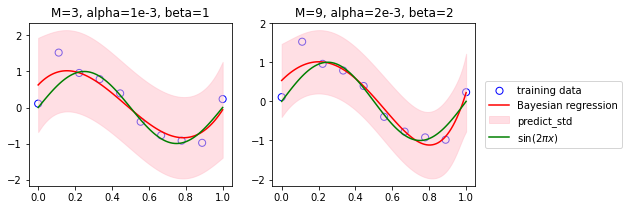

In [17]:
#input x_train shape (10,) other than (10,1) for sklearn polyfeature function
#f3_train=PolynomialFeatures(degree=3).fit_transform(x_train.reshape(-1,1))

my_poly_3=MyPolynomialFeatures(degree=3)
f3_train=my_poly_3.transform(x_train)
f3_test=my_poly_3.transform(x_test)

my_poly_9=MyPolynomialFeatures(degree=9)
f9_train=my_poly_9.transform(x_train)
f9_test=my_poly_9.transform(x_test)

my_br=MyBayesianRegression(alpha=1e-3,beta=1)
my_br.fit(f3_train,y_train)
y3,y3_std=my_br.predict(f3_test)

my_br=MyBayesianRegression(alpha=2e-3,beta=2)
my_br.fit(f9_train,y_train)
y9,y9_std=my_br.predict(f9_test)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.scatter(x_train,y_train,facecolor='none',edgecolor='b',s=50,label='training data')
plt.plot(x_test,y3,c='r',label='Bayesian regression')
plt.fill_between(x_test, y3 - y3_std, y3 + y3_std, color='pink', alpha=0.5, label="predict_std")
plt.plot(x_test,y_test,c='g',label='$\sin(2\pi x)$')
plt.title('M=3, alpha=1e-3, beta=1')
#plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)

plt.subplot(122)
plt.scatter(x_train,y_train,facecolor='none',edgecolor='b',s=50,label='training data')
plt.plot(x_test,y9,c='r',label='Bayesian regression')
plt.fill_between(x_test, y9 - y9_std, y9 + y9_std, color='pink', alpha=0.5, label="predict_std")
plt.plot(x_test,y_test,c='g',label='$\sin(2\pi x)$')
plt.title('M=9, alpha=2e-3, beta=2')
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)

# RECALL 2 - Gaussian Maximum likelihood

#### Gaussian Maximum likelihood

suppose a data set of observation 

$\textbf{x}=(x_1,...,x_N)^T$

and suppose the observations are drawn independently from a Gaussian distribution whose $\mu$ and $\sigma$ are unknown

Goal: to determine $\mu$ and $\sigma$ from the data set

since data $\textbf{x}$ is i.i.d

we can write the probability of the data set, which is the **likelihood** function, given by parameters

$p(\textbf{x}|\mu,\sigma^2)=\prod_{n=1}^N \mathcal{N}(x_n|\mu,\sigma^2)$

<img src="http://norman3.github.io/prml/images/Figure1.14.png" width="300"/>


the black dots are data set, simply $x_1,...,x_n,...$

the blue dots are the Gaussian likelihood of each data points

the likelihood is the product of each blue dots

**maximum likelihood**

to find the parameter values that maximize the likelihood function

maximize the prob of the parameters given the data?

or maximize the prob of the data given the parameter?

**maximize the log of the likelihood**

log is a monotonically increasing function 

max log of the function is equivalent to max the function itself

(+) log simplifies the subsequent math analysis

(+) helps numerically because the product of a large number of small probabilities can easily underflow the numerical precision of the computer


take log of the likelihood function

$\ln p(\textbf{x}|\mu,\sigma^2)=-1/(2\sigma^2) \sum_{n=1}^N (x_n-\mu)^2 - N/2 \ln \sigma^2 - N/2 \ln (2\pi)$

max the above function w.r.t $\mu$, we have

$\mu_{ML}=1/N \sum_{n=1}^N x_n$ <- sample mean

max w.r.t $\sigma^2$

$\sigma_{ML}^2=1/N \sum_{n=1}^N(x_n-\mu_{ML})^2$ <- sample variance

**maximum likelihood underestimates the variance which causes bias**

an example of 'bias' related to over-fitting

since 

$\mathbb{E} [\mu_{ML}]=\mu$

$\mathbb{E} [\sigma_{ML}^2]=\frac{N-1}{N} \sigma^2$

the unbiased estimated variance is 

$\tilde{\sigma}^2=\frac{N}{N-1}\sigma_{ML}^2=1/(N-1) \sum_{n=1}^N (x_n-\mu_{ML})^2$

when data set is small, the bias is significant

when $N$->$\infty$, $\sigma_{ML}$-> true $\sigma$

# RECALL 3 - probability theory

- in a fully Bayesian approach, we should consistently apply the **sum and product rules**

- **marginalizations** - integrate over all values

marginalizations lies in the heart of Bayesian approach

#### probability theory

uncertainty - from noise and the finite size of data sets

probability theory provides a consistent framework for the quantification and manipulation of uncertainty

**simple example**

2 boxes, red and blue

red has 2 apples and 6 oranges

blue has 3 apples and 1 orange

we randomly pick one of the boxes, and from that box we randomly select an fruit

after observing which fruit it is we replace it in the box from which it came

we repeat this process many times

suppose we pick the red box 40% and blue 60% of the time

we have

random variable $B$ - which box to choose, r or b

random variable $F$ - which fruit to pick, a or o

to begin with, we shall define the probability of an event to be the fraction of times that event occurs out of the total number of trials, in the limit that the total number of trials goes to infinity

$p(B=r)=4/10$

$p(B=b)=6/10$

questions:

1. what is the overall probability that the selection procedure will pick an apple?

2. given that we have chosen an orange, what is the probability that the box we chose was the blue?

****

**more generally**

we have two random variables $X$ and $Y$

$X$ can take any of the values $x_i$, where $i=1,...,M$

$Y$ can take any of the values $y_j$, where $j=1,...,L$

consider a total of $N$ trials

which we can sample both $X$ and $Y$, and let the number of such trials be $n_{ij}$

let the number of trials of $X$ taking $x_i$ be $c_i$ (irrespective of whatever $Y$ takes)

the number of trials of $Y$ taking $y_j$ be $r_j$ 

$p(X=x_i,Y=y_j)$ - the **joint probability** of $X=x_i,Y=y_j$

$p(X=x_i,Y=y_j)=n_{ij}/N$

$p(X=x_i)=c_i/N$

$c_i=\sum_j n_{ij}$

suppose $M=5$, $L=3$, $c_4=n_{41}+n_{42}+n_{43}$

**sum rule**

$p(X=x_i)=\sum_{j=1}^L p(X=x_i,Y=y_j)$

$p(X=x_i)$ - **marginal** probability, because it is obtained by marginalizing, or summing out, the other variables (in this case Y )

**product rule**

$p(Y=y_j|X=x_i)=n_{ij}/c_i$ 

$p(Y=y_j|X=x_i)$ - **conditional** probability of $Y$ given $X$

$p(Y=y_j|X=x_i)=n_{ij}/N=n_{ij}/c_i \cdot c_i/N=p(Y=y_j|X=x_i)p(X=x_i)$

**for simplicity**

$p(B)$ - a distribution over the random variable $B$

$p(B=r)$->$p(r)$ - the distribution evaluated for the particular value $r$

so 

**sum rule**: $p(X)=\sum_{Y}p(X,Y)$

**product rule**: $p(X,Y)=p(Y|X)p(X)$

$p(X,Y)$ - the probability of $X$ and $Y$

$p(Y|X)$ - the probability of $Y$ given $X$

$p(X)$ - the probability of $X$, a marginal probability

**Baye's theorem**

based on the symmetry: $p(X,Y)=p(Y,X)=p(Y|X)p(X)=p(X|Y)p(Y)$

$p(Y|X)=\frac{p(X,Y)}{p(X)}=\frac{p(X|Y)p(Y)}{p(X)}$

since $p(X)=\sum_{Y}p(X,Y)=\sum_{Y} p(X|Y)p(Y)$

$p(Y|X)=\frac{p(X|Y)p(Y)}{\sum_Y p(X|Y)p(Y)}$

the denominator - the normalization constant ensures that the sum of the conditional probability $p(Y|X)$ equals one

**independent**

if the joint distribution of two variables factorized into the product of the marginals $p(X,Y)=p(X)p(Y)$

then $X$ and $Y$ are said to be independent

from the product rule, $p(Y|X)=p(Y)$

if each box contained the same fraction of apples and oranges, then $p(F|B)=p(F)$

so that the probability of selecting an apple is independent of which box is chosen

****

back to the **simple example** of fruit box

$p(B=r)=4/10$

$p(B=b)=6/10$

$p(F=a|B=b)=3/4$

$p(F=o|B=b)=1/4$

$p(F=a|B=r)=1/4$

$p(F=o|B=r)=3/4$

questions:

1. what is the overall probability that the selection procedure will pick an apple?

$p(F=a)=p(F=a|B=r)p(B=r)+p(F=a|B=b)p(B=b)=1/4\cdot4/10+3/4\cdot6/10=11/20$

$p(F=o)=1-11/20=9/20$

2. given that we have chosen an orange, what is the probability that the box we chose was the blue?

$p(B=r|F=o)=\frac{p(F=o|B=r)p(B=r)}{p(F=o)}=3/4\cdot4/10\cdot20/9=2/3$

$p(B=b|F=o)=1-2/3=1/3$

$p(B)$ - which box had been chosen before being told the identity of the selected item of fruit

$p(B)$ - **prior probability** - because it is available **before** we observe the identity of the fruit

$P(B|F)$ - once we are told that the fruit is an orange, we can use Bayes' theorem to compute this probability

$P(B|F)$ - **posterior probability** - bacause it is the probability obtained **after** we have observed $F$

ref:

https://github.com/ctgk/PRML

https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression

https://www.linuxtut.com/en/555802600638f41b40c5/